Given a new purchase order, what is the predicted actual lead time?

In [2]:
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from IPython.display import display

DATA_PATH = Path().cwd().parent / "data"

def read_data(file_name):
    return pl.read_csv(DATA_PATH / file_name, try_parse_dates=True)

ship_df = read_data("shipments.csv")
purchase_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
sku_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_returns_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")

In [3]:
# Quick peek at key tables to understand available fields
preview_tables = {
    "shipments": ship_df.head(3).to_pandas(),
    "purchase_orders": purchase_df.head(3).to_pandas(),
    "transit_events": transit_events_df.head(3).to_pandas(),
}
for name, frame in preview_tables.items():
    print(f"\n{name.upper()} columns: {frame.columns.tolist()}")
    display(frame)



SHIPMENTS columns: ['shipment_id', 'po_id', 'ship_qty', 'mode', 'incoterm', 'origin_country', 'dest_site_id', 'ship_date', 'eta_date', 'status']


,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit



PURCHASE_ORDERS columns: ['po_id', 'supplier_id', 'sku_id', 'order_qty', 'unit_price_usd', 'order_date', 'promised_date', 'region', 'country', 'status']


,po_id,supplier_id,sku_id,order_qty,unit_price_usd,order_date,promised_date,region,country,status
0,PO-0000001,S-0161,SKU-02137,14,305.99,2024-02-17,2024-03-15,EMEA,France,Closed
1,PO-0000002,S-0043,SKU-04868,6,197.63,2024-12-31,2025-01-23,EMEA,UK,Open
2,PO-0000003,S-0055,SKU-02915,9,140.06,2023-05-04,2023-05-26,EMEA,UK,Closed



TRANSIT_EVENTS columns: ['shipment_id', 'event_ts', 'location_type', 'event_status']


,shipment_id,event_ts,location_type,event_status
0,SH-00145406,2023-01-01,On Vehicle,Picked
1,SH-00074867,2023-01-01,Regional Hub,Out for Delivery
2,SH-00132727,2023-01-01,Destination,In Transit


In [4]:
# Basic distributions to understand shipment and event statuses
status_summary = ship_df.group_by("status").len().sort("len", descending=True)
event_status_summary = transit_events_df.group_by("event_status").len().sort("len", descending=True)

print("Shipment status distribution (top 10):")
display(status_summary.head(10).to_pandas())
print("\nTransit event status distribution (top 10):")
display(event_status_summary.head(10).to_pandas())

Shipment status distribution (top 10):


,status,len
0,In Transit,97648
1,Delivered,82824
2,Created,21626
3,Delayed,13246
4,Lost,2156



Transit event status distribution (top 10):


,event_status,len
0,In Transit,100252
1,Delivered,63768
2,Arrived Hub,51925
3,Out for Delivery,43920
4,Created,32140
5,Released,28172
6,Picked,27921
7,Departed Origin,27874
8,Customs Hold,24028


In [11]:
# Build enriched shipment table with computed lead times, observed/estimated delays, and narratives
from datetime import datetime

# Delivered event timestamps per shipment
actual_delivery = (
    transit_events_df
    .filter(pl.col("event_status") == "Delivered")
    .group_by("shipment_id")
    .agg(pl.col("event_ts").max().alias("actual_delivery_ts"))
)

# Latest known event timestamp + status per shipment (covers shipments without delivery events)
latest_event = (
    transit_events_df
    .group_by("shipment_id")
    .agg([
        pl.col("event_ts").max().alias("last_event_ts"),
        pl.col("event_status").sort_by("event_ts").last().alias("last_event_status"),
    ])
)

shipments_enriched = (
    ship_df
    .join(latest_event, on="shipment_id", how="left")
    .join(actual_delivery, on="shipment_id", how="left")
    .join(
        purchase_df.select("po_id", "order_date", "promised_date", "supplier_id"),
        on="po_id",
        how="left"
    )
    .with_columns([
        (pl.col("eta_date") - pl.col("ship_date")).dt.total_days().cast(pl.Int32).alias("planned_transit_days"),
        (pl.col("promised_date") - pl.col("order_date")).dt.total_days().cast(pl.Int32).alias("promised_lead_time_days"),
        (pl.col("actual_delivery_ts") - pl.col("ship_date")).dt.total_days().cast(pl.Int32).alias("actual_transit_days"),
        (pl.col("actual_delivery_ts") - pl.col("order_date")).dt.total_days().cast(pl.Int32).alias("actual_lead_time_days"),
        (pl.col("actual_delivery_ts") - pl.col("eta_date")).dt.total_days().cast(pl.Int32).alias("delay_vs_eta_days"),
        (pl.col("actual_delivery_ts") - pl.col("promised_date")).dt.total_days().cast(pl.Int32).alias("delay_vs_promised_days"),
        pl.when(pl.col("actual_delivery_ts").is_not_null())
        .then(pl.col("actual_delivery_ts"))
        .otherwise(pl.col("last_event_ts"))
        .alias("best_available_ts"),
    ])
    .with_columns([
        (pl.col("best_available_ts") - pl.col("eta_date")).dt.total_days().cast(pl.Int32).alias("latest_known_delay_vs_eta_days"),
        (pl.col("best_available_ts") - pl.col("promised_date")).dt.total_days().cast(pl.Int32).alias("latest_known_delay_vs_promised_days"),
    ])
    .with_columns([
        pl.when(pl.col("actual_delivery_ts").is_null() & pl.col("best_available_ts").is_not_null())
        .then(pl.col("latest_known_delay_vs_eta_days"))
        .otherwise(pl.col("delay_vs_eta_days"))
        .alias("best_delay_vs_eta_days"),
        pl.when(pl.col("actual_delivery_ts").is_null() & pl.col("best_available_ts").is_not_null())
        .then(pl.col("latest_known_delay_vs_promised_days"))
        .otherwise(pl.col("delay_vs_promised_days"))
        .alias("best_delay_vs_promised_days"),
    ])
    .with_columns([
        pl.when(pl.col("best_delay_vs_eta_days").is_null())
        .then(pl.lit(None))
        .otherwise(pl.col("best_delay_vs_eta_days") > 0)
        .alias("is_delayed_computed"),
        pl.when(pl.col("actual_delivery_ts").is_null())
        .then(
            pl.when(pl.col("best_available_ts").is_null())
            .then(pl.lit("No transit events ingested"))
            .otherwise(
                pl.concat_str([
                    pl.lit("Latest status: "),
                    pl.col("last_event_status").fill_null("Unknown"),
                    pl.lit(" ("),
                    pl.when(pl.col("best_delay_vs_eta_days").is_null())
                    .then(pl.lit("?"))
                    .otherwise(pl.col("best_delay_vs_eta_days").cast(pl.Int32).cast(pl.Utf8)),
                    pl.lit(" days vs ETA)"),
                ])
            )
        )
        .otherwise(
            pl.when(pl.col("delay_vs_eta_days") > 0)
            .then(pl.concat_str([
                pl.lit("Arrived "),
                pl.col("delay_vs_eta_days").cast(pl.Int32).cast(pl.Utf8),
                pl.lit(" days after ETA"),
            ]))
            .when(pl.col("delay_vs_eta_days") < 0)
            .then(pl.concat_str([
                pl.lit("Arrived "),
                (-pl.col("delay_vs_eta_days")).cast(pl.Int32).cast(pl.Utf8),
                pl.lit(" days before ETA"),
            ]))
            .otherwise(pl.lit("Arrived on ETA"))
        )
        .alias("delay_narrative"),
    ])
)

shipments_enriched.head(3).to_pandas()

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,...,actual_lead_time_days,delay_vs_eta_days,delay_vs_promised_days,best_available_ts,latest_known_delay_vs_eta_days,latest_known_delay_vs_promised_days,best_delay_vs_eta_days,best_delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,None,No transit events ingested
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed,...,NaN,NaN,NaN,2024-03-09 04:00:00,-201.0,-294.0,-201.0,-294.0,False,Latest status: Out for Delivery (-201 days vs ...
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,...,NaN,NaN,NaN,2023-02-27 07:00:00,28.0,-441.0,28.0,-441.0,True,Latest status: In Transit (28 days vs ETA)


In [8]:
ship_df.dtypes, purchase_df.dtypes, transit_events_df.dtypes

([String, String, Int64, String, String, String, String, Date, Date, String],
 [String, String, String, Int64, Float64, Date, Date, String, String, String],
 [String, Datetime(time_unit='us', time_zone=None), String, String])

In [9]:
shipments_enriched.select([
    pl.col("actual_delivery_ts").is_not_null().sum().alias("deliveries_captured"),
    pl.len().alias("total_shipments")
])

deliveries_captured,total_shipments
u32,u32
55232,217500


In [6]:
# Helper to inspect a single shipment across all relevant sources
def explain_shipment_delay(shipment_id: str):
    record = shipments_enriched.filter(pl.col("shipment_id") == shipment_id)
    if record.is_empty():
        print(f"Shipment {shipment_id} not found.")
        return
    detail_cols = [
        "shipment_id",
        "po_id",
        "supplier_id",
        "ship_date",
        "eta_date",
        "status",
        "actual_delivery_ts",
        "planned_transit_days",
        "actual_transit_days",
        "delay_vs_eta_days",
        "promised_lead_time_days",
        "actual_lead_time_days",
        "delay_vs_promised_days",
        "is_delayed_computed",
        "delay_narrative",
    ]
    display(record.select(detail_cols).to_pandas())

    timeline = (
        transit_events_df
        .filter(pl.col("shipment_id") == shipment_id)
        .sort("event_ts")
    )
    if timeline.is_empty():
        print("No transit events captured for this shipment.")
    else:
        print("Transit timeline (sorted):")
        display(timeline.to_pandas())

# Example usage (feel free to swap IDs)
explain_shipment_delay("SH-00000002")

,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000002,PO-0099598,S-0002,2024-08-21,2024-09-27,Delayed,NaT,37,NaN,NaN,18,NaN,NaN,None,No delivery event yet


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000002,2024-03-09 04:00:00,Final DC,Out for Delivery


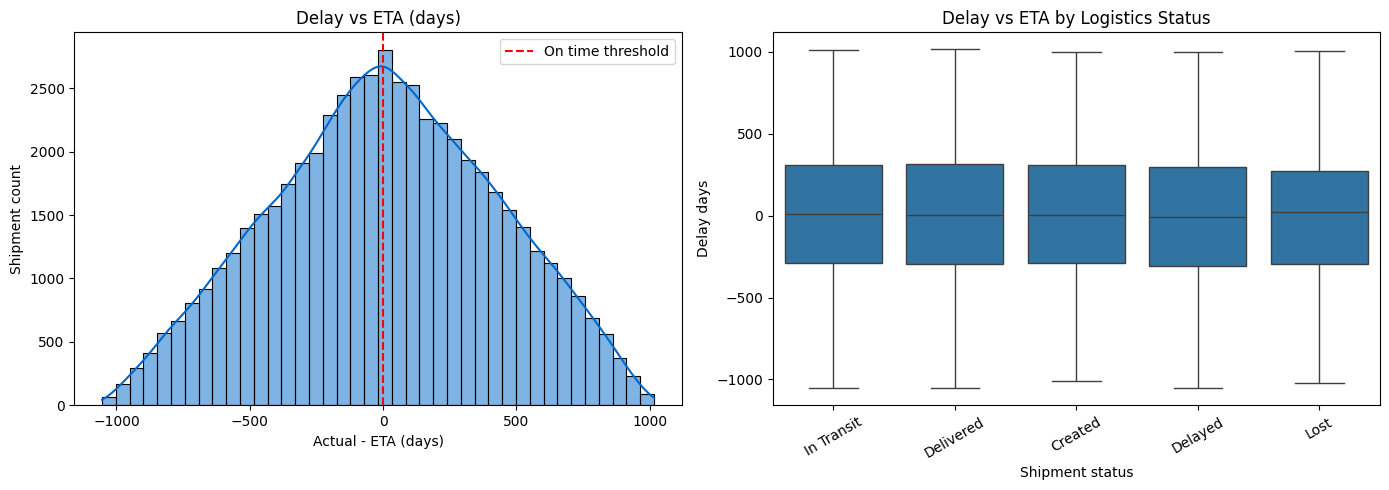

Delay summary by shipment.status (delivered only):


,status,delivered_samples,avg_delay_days,median_delay_days
0,In Transit,24780,7.910654,9.0
1,Delivered,20988,7.251096,6.0
2,Created,5474,6.447936,4.5
3,Delayed,3443,-7.300029,-10.0
4,Lost,547,1.524680,21.0


In [7]:
# Visualize delay distributions for shipments that have delivered events
plot_ready = shipments_enriched.filter(pl.col("delay_vs_eta_days").is_not_null())
plot_df = plot_ready.select([
    "delay_vs_eta_days",
    "delay_vs_promised_days",
    "status"
]).to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(plot_df["delay_vs_eta_days"], bins=40, kde=True, ax=axes[0], color="#0068c9")
axes[0].axvline(0, color="red", linestyle="--", label="On time threshold")
axes[0].set_title("Delay vs ETA (days)")
axes[0].set_xlabel("Actual - ETA (days)")
axes[0].set_ylabel("Shipment count")
axes[0].legend()

sns.boxplot(data=plot_df, x="status", y="delay_vs_eta_days", ax=axes[1])
axes[1].set_title("Delay vs ETA by Logistics Status")
axes[1].set_xlabel("Shipment status")
axes[1].set_ylabel("Delay days")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

summary_df = (
    plot_ready
    .group_by("status")
    .agg([
        pl.len().alias("delivered_samples"),
        pl.col("delay_vs_eta_days").mean().alias("avg_delay_days"),
        pl.col("delay_vs_eta_days").median().alias("median_delay_days")
    ])
    .sort("delivered_samples", descending=True)
)
print("Delay summary by shipment.status (delivered only):")
display(summary_df.to_pandas().head(10))

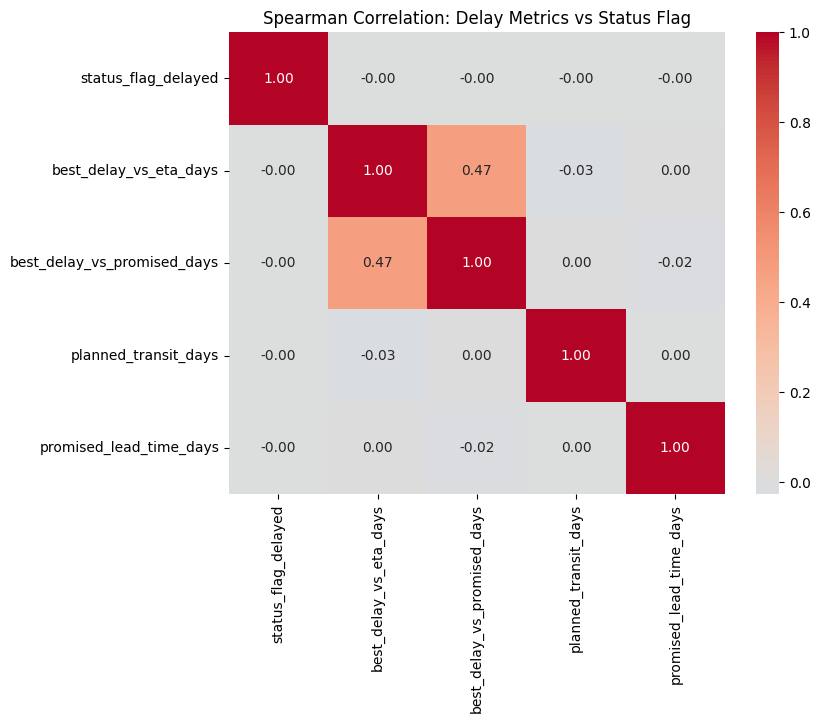

Correlation of status flag with each delay signal:


,best_delay_vs_eta_days,best_delay_vs_promised_days
status_flag_delayed,-0.002676,-0.001531


In [12]:
# Correlation between shipment.status flag and computed delays
corr_input = (
    shipments_enriched
    .select([
        pl.when(pl.col("status") == "Delayed").then(1).otherwise(0).alias("status_flag_delayed"),
        pl.col("best_delay_vs_eta_days"),
        pl.col("best_delay_vs_promised_days"),
        pl.col("planned_transit_days"),
        pl.col("promised_lead_time_days"),
    ])
    .drop_nulls()
)

corr_df = corr_input.to_pandas()
corr_matrix = corr_df.corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Spearman Correlation: Delay Metrics vs Status Flag")
plt.show()

print("Correlation of status flag with each delay signal:")
display(corr_matrix.loc[["status_flag_delayed"], ["best_delay_vs_eta_days", "best_delay_vs_promised_days"]])

In [13]:
# Identify sample shipments for deeper inspection
samples = {
    "delayed_flag_no_delivery": (
        shipments_enriched
        .filter((pl.col("status") == "Delayed") & pl.col("actual_delivery_ts").is_null())
        .select("shipment_id")
        .head(2)
        .to_series()
        .to_list()
    ),
    "delayed_flag_arrived_early": (
        shipments_enriched
        .filter((pl.col("status") == "Delayed") & (pl.col("best_delay_vs_eta_days") < 0))
        .select("shipment_id")
        .head(2)
        .to_series()
        .to_list()
    ),
    "on_time_flag_but_late": (
        shipments_enriched
        .filter((pl.col("status") != "Delayed") & (pl.col("best_delay_vs_eta_days") > 20))
        .select("shipment_id")
        .head(2)
        .to_series()
        .to_list()
    ),
}

samples

{'delayed_flag_no_delivery': ['SH-00000002', 'SH-00000020'],
 'delayed_flag_arrived_early': ['SH-00000002', 'SH-00000288'],
 'on_time_flag_but_late': ['SH-00000003', 'SH-00000004']}

In [14]:
# Inspect selected shipments using the helper
unique_samples = list({sid for cat in samples.values() for sid in cat})
for sid in unique_samples:
    print("=" * 40)
    print(f"Shipment: {sid}")
    explain_shipment_delay(sid)

Shipment: SH-00000004


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000004,PO-0047627,S-0091,2023-07-03,2023-08-05,In Transit,2025-09-02 20:00:00,33,792,759,35,310,275,True,Arrived 759 days after ETA


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000004,2024-05-22 15:00:00,Destination,Arrived Hub
1,SH-00000004,2024-06-03 01:00:00,Rail Yard,Released
2,SH-00000004,2024-08-26 12:00:00,Origin DC,Arrived Hub
3,SH-00000004,2025-09-02 20:00:00,Rail Yard,Delivered


Shipment: SH-00000003


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000003,PO-0110843,S-0178,2023-01-21,2023-01-30,In Transit,NaT,9,NaN,NaN,16,NaN,NaN,True,Latest status: In Transit (28 days vs ETA)


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000003,2023-02-27 07:00:00,Destination,In Transit


Shipment: SH-00000020


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000020,PO-0097987,S-0200,2023-04-21,2023-05-29,Delayed,NaT,38,NaN,NaN,42,NaN,NaN,None,No transit events ingested


No transit events captured for this shipment.
Shipment: SH-00000002


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000002,PO-0099598,S-0002,2024-08-21,2024-09-27,Delayed,NaT,37,NaN,NaN,18,NaN,NaN,False,Latest status: Out for Delivery (-201 days vs ...


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000002,2024-03-09 04:00:00,Final DC,Out for Delivery


Shipment: SH-00000288


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000288,PO-0002958,S-0025,2024-12-18,2025-01-21,Delayed,NaT,34,NaN,NaN,37,NaN,NaN,False,Latest status: Picked (-93 days vs ETA)


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000288,2023-05-15 23:00:00,On Vehicle,Created
1,SH-00000288,2024-10-19 03:00:00,Airport,Picked


In [15]:
# Compare status flag vs computed delay classification
comparison = (
    shipments_enriched
    .select([
        pl.col("status").alias("status_flag"),
        pl.when(pl.col("status") == "Delayed").then(1).otherwise(0).alias("status_flag_delayed"),
        pl.col("best_delay_vs_eta_days").alias("delay_days"),
    ])
    .drop_nulls()
    .with_columns([
        (pl.col("delay_days") > 0).alias("computed_delayed"),
    ])
)

confusion = (
    comparison
    .group_by("status_flag", "computed_delayed")
    .len()
    .pivot(
        values="len",
        index="status_flag",
        columns="computed_delayed"
    )
    .fill_null(0)
    .rename({"false": "On-time (<=0)", "true": "Late (>0)"})
)

print("Confusion matrix between status flag and computed delay > 0:")
display(confusion.to_pandas())

mislabel_rate = (
    comparison
    .with_columns((pl.col("status_flag_delayed") == pl.col("computed_delayed")).alias("matches"))
    .select([
        pl.len().alias("sample_size"),
        pl.col("matches").sum().alias("matching"),
        (1 - pl.col("matches").mean()).alias("mislabel_rate")
    ])
)
print("Overall agreement between status flag and computed delay:")
display(mislabel_rate.to_pandas())

Confusion matrix between status flag and computed delay > 0:


C:\Users\skibi\AppData\Local\Temp\ipykernel_128924\698343391.py:19: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


,status_flag,Late (>0),On-time (<=0)
0,In Transit,47365,34830
1,Created,10453,7753
2,Lost,1084,743
3,Delivered,40145,29457
4,Delayed,6359,4770


Overall agreement between status flag and computed delay:


,sample_size,matching,mislabel_rate
0,182959,79142,0.567433


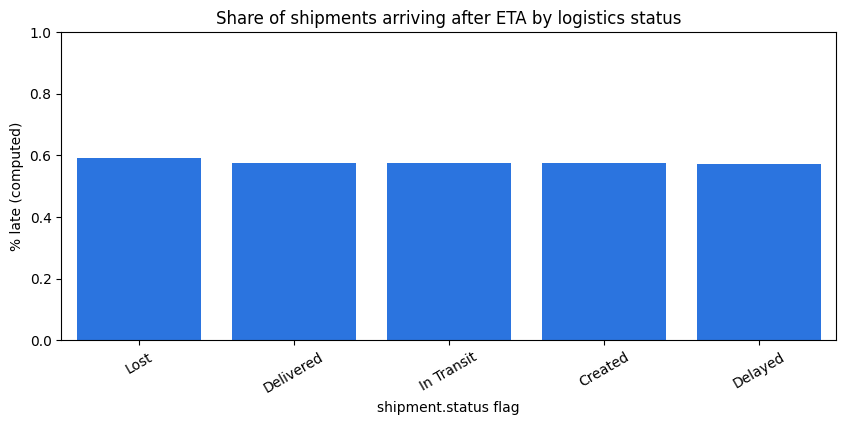

Delay stats by logistics status (sorted by share late):


,status,samples,share_late,avg_delay,median_delay
0,Lost,1827,0.593322,84.999453,89.0
1,Delivered,69602,0.576779,80.114278,85.0
2,In Transit,82195,0.576252,79.485759,81.0
3,Created,18206,0.574151,82.136329,81.0
4,Delayed,11129,0.571390,74.856231,77.0


In [16]:
# Share of shipments with positive computed delay by logistics status
status_delay_share = (
    shipments_enriched
    .select([
        "status",
        pl.col("best_delay_vs_eta_days").alias("delay_days"),
    ])
    .drop_nulls()
    .group_by("status")
    .agg([
        pl.len().alias("samples"),
        (pl.col("delay_days") > 0).mean().alias("share_late"),
        pl.col("delay_days").mean().alias("avg_delay"),
        pl.col("delay_days").median().alias("median_delay"),
    ])
    .sort("share_late", descending=True)
)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=status_delay_share.to_pandas(),
    x="status",
    y="share_late",
    hue=None,
    color="#0d6efd"
)
plt.title("Share of shipments arriving after ETA by logistics status")
plt.ylabel("% late (computed)")
plt.xlabel("shipment.status flag")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

print("Delay stats by logistics status (sorted by share late):")
display(status_delay_share.to_pandas())